In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import matplotlib.ticker as tkr
from scipy import stats

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #Using CPU here as GPU's RAM is not sufficient for the training

2026-02-07 09:52:56.360463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 09:52:56.735799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-07 09:52:58.216129: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

In [ ]:
df=pd.read_csv('./Dataset/Dataset.txt', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2075259, 9)


/tmp/ipykernel_7670/982856174.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../Dataset/Dataset.txt', delimiter=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
cols_to_process=df.select_dtypes(include='object').columns.difference(["Date","Time"])
df[cols_to_process]=df[cols_to_process].apply(
    lambda col: pd.to_numeric(col,errors='coerce')
)
df = df.dropna(subset=cols_to_process)
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power','Global_intensity' ,'Sub_metering_1','Sub_metering_2','Sub_metering_3','year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

/tmp/ipykernel_7670/3841490736.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


(2049280, 11)
2006-12-16 17:24:00
2010-11-26 21:02:00


,date_time,Global_active_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,quarter,month,day,weekday
2049275,2010-11-26 20:58:00,0.946,4.0,0.0,0.0,0.0,2010,4,11,26,1
2049276,2010-11-26 20:59:00,0.944,4.0,0.0,0.0,0.0,2010,4,11,26,1
2049277,2010-11-26 21:00:00,0.938,3.8,0.0,0.0,0.0,2010,4,11,26,1
2049278,2010-11-26 21:01:00,0.934,3.8,0.0,0.0,0.0,2010,4,11,26,1
2049279,2010-11-26 21:02:00,0.932,3.8,0.0,0.0,0.0,2010,4,11,26,1


In [5]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())
df.dtypes

Number of rows and columns after removing missing values: (2049280, 11)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-11-26 21:02:00


date_time              datetime64[ns]
Global_active_power           float64
Global_intensity              float64
Sub_metering_1                float64
Sub_metering_2                float64
Sub_metering_3                float64
year                            int64
quarter                         int64
month                           int64
day                             int64
weekday                         int64
dtype: object

In [6]:
dataset = df.select_dtypes(include='number').values #numpy.ndarray
print(dataset.shape)
dataset = dataset.astype('float32')
dataset = np.log1p(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

(2049280, 10)


In [7]:
series = dataset.astype("float32")
print(series.shape)
split = int(0.8 * len(series))
train_series = series[:split]
test_series  = series[split:]
print(series[-1:,:1])

(2049280, 10)
[[0.24168476]]


In [8]:
def make_window_dataset(series, look_back, batch_size, target_col=0):
    ds = tf.data.Dataset.from_tensor_slices(series)

    ds = ds.window(
        look_back + 1,
        shift=1,
        drop_remainder=True
    )

    ds = ds.flat_map(lambda w: w.batch(look_back + 1))

    ds = ds.map(
        lambda w: (
            w[:-1, :],          # X: all features, past L steps
            w[-1, target_col]   # Y: target at time t
        )
    )

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [9]:
# reshape into X=t and Y=t+1
look_back = 60
batch_size = 32
target_col=0
train_ds = make_window_dataset(train_series, look_back, batch_size,target_col)
test_ds  = make_window_dataset(test_series,  look_back, batch_size,target_col)


2026-02-07 09:53:28.758304: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-02-07 09:53:28.758329: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-02-07 09:53:28.758333: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-02-07 09:53:28.758336: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-02-07 09:53:28.758340: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: bhavya-bisen-GF63-Thin-11UC
2026-02-07 09:53:28.758342: I external/local_xla/xla/stream

In [10]:
for x, y in train_ds.take(1):
    print(x.shape, y.shape)

(32, 60, 10) (32,)


2026-02-07 09:53:28.908362: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(look_back,10)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_ds,epochs=50, batch_size=64, validation_data=(test_ds), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20,restore_best_weights=True)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/50


/home/bhavya-bisen/Desktop/AI learning/Scratch/Power Consuption Pridiction Model/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  51231/Unknown 591s 12ms/step - loss: 0.0034

2026-02-06 20:58:17.081098: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/bhavya-bisen/Desktop/AI learning/Scratch/Power Consuption Pridiction Model/venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 646s 13ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 2/50
   10/51231 ━━━━━━━━━━━━━━━━━━━━ 10:40 12ms/step - loss: 0.0101

2026-02-06 20:59:12.407328: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 627s 12ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/50
   11/51231 ━━━━━━━━━━━━━━━━━━━━ 9:54 12ms/step - loss: 0.0185 

2026-02-06 21:09:39.418303: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 622s 12ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 624s 12ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/50
   16/51231 ━━━━━━━━━━━━━━━━━━━━ 9:28 11ms/step - loss: 0.0233

2026-02-06 21:30:25.619591: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 624s 12ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 624s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 625s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 626s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/50
   15/51231 ━━━━━━━━━━━━━━━━━━━━ 10:05 12ms/step - loss: 0.0201

2026-02-06 22:12:04.979571: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 614s 12ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 602s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 603s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 603s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 13/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 605s 12ms/step - loss: 0.0012 - val_loss: 9.8612e-04
Epoch 14/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 608s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 15/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 610s 12ms/step - loss: 0.0012 - val_loss: 9.8265e-04
Epoch 16/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 611s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 17/50
   14/51231 ━━━━━━━━━━━━━━━━━━━━ 10:37 12ms/step - loss: 0.0151

2026-02-06 23:33:01.955811: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 603s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 18/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 605s 12ms/step - loss: 0.0012 - val_loss: 9.8881e-04
Epoch 19/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 607s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 20/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 607s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 21/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 607s 12ms/step - loss: 0.0012 - val_loss: 9.8054e-04
Epoch 22/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 608s 12ms/step - loss: 0.0012 - val_loss: 9.8870e-04
Epoch 23/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 614s 12ms/step - loss: 0.0012 - val_loss: 9.8057e-04
Epoch 24/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 609s 12ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 25/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 611s 12ms/step - loss: 0.0012 - val_loss: 9.7074e-04
Epoch 26/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 611s 12ms/step - loss: 0.0011 - val_loss: 9.6145e-04
Epoch 27/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 611

2026-02-07 02:15:33.966970: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


51231/51231 ━━━━━━━━━━━━━━━━━━━━ 596s 12ms/step - loss: 0.0203 - val_loss: 0.0232
Epoch 34/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 597s 12ms/step - loss: 0.0200 - val_loss: 0.0203
Epoch 35/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 597s 12ms/step - loss: 0.0187 - val_loss: 0.0201
Epoch 36/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 598s 12ms/step - loss: 0.0193 - val_loss: 0.0212
Epoch 37/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 598s 12ms/step - loss: 0.0189 - val_loss: 0.0240
Epoch 38/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 598s 12ms/step - loss: 0.0184 - val_loss: 0.0221
Epoch 39/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 599s 12ms/step - loss: 0.0177 - val_loss: 0.0218
Epoch 40/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 599s 12ms/step - loss: 0.0177 - val_loss: 0.0195
Epoch 41/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 599s 12ms/step - loss: 0.0170 - val_loss: 0.0232
Epoch 42/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 601s 12ms/step - loss: 0.0194 - val_loss: 0.0253
Epoch 43/50
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 601s 12ms/step - loss: 0.01

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,797 (225.77 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,532 (150.52 KB)

In [ ]:
# model.save("./keras/power_lstm_model.keras")
# model.export("./export/power_lstm_model")

INFO:tensorflow:Assets written to: ./export/power_lstm_model/assets


INFO:tensorflow:Assets written to: ./export/power_lstm_model/assets


Saved artifact at './export/power_lstm_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 10), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136331154242928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136331017291200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136331017876960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136331017305104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136331017305808: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [13]:
from tensorflow.keras.models import load_model
model=load_model("./keras/power_lstm_model.keras",compile=True)

In [14]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(series[:, target_col].reshape(-1, 1))


# make predictions
y_train_predict=model.predict(train_ds)
y_test_predict=model.predict(test_ds)
y_true_scaled_train = np.concatenate(
    [y.numpy() for _, y in train_ds],
    axis=0
).reshape(-1, 1)
y_true_scaled_test = np.concatenate(
    [y.numpy() for _, y in test_ds],
    axis=0
).reshape(-1, 1)
# invert predictions
train_predict = target_scaler.inverse_transform(y_train_predict)
Y_train = target_scaler.inverse_transform(y_true_scaled_train)
test_predict = target_scaler.inverse_transform(y_test_predict)
Y_test = target_scaler.inverse_transform(y_true_scaled_test)

train_predict=np.expm1(train_predict)
Y_train=np.expm1(Y_train)
test_predict=np.expm1(test_predict)
Y_test=np.expm1(Y_test)

51231/51231 ━━━━━━━━━━━━━━━━━━━━ 188s 4ms/step


2026-02-07 09:57:09.499926: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/bhavya-bisen/Desktop/AI learning/Scratch/Power Consuption Pridiction Model/venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12807/12807 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step


2026-02-07 10:00:09.118292: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Train Mean Absolute Error: 0.05893491208553314
Train Root Mean Squared Error: 0.09273166720029143
Test Mean Absolute Error: 0.02157445438206196
Test Root Mean Squared Error: 0.04334048518040984


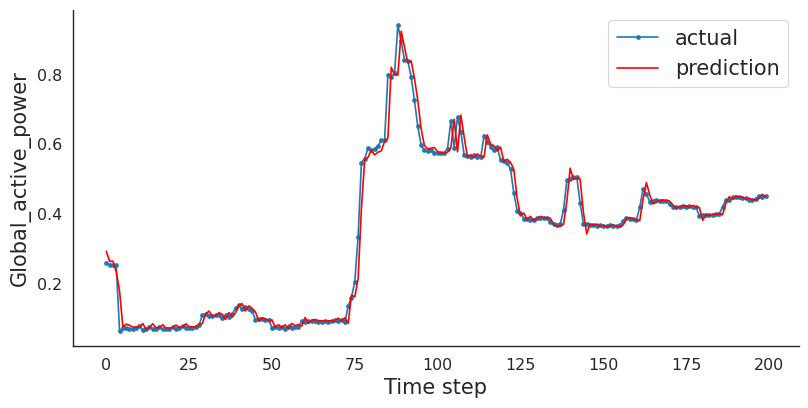

In [23]:


aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:200], marker='.', label="actual")
plt.plot(aa, test_predict[:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()



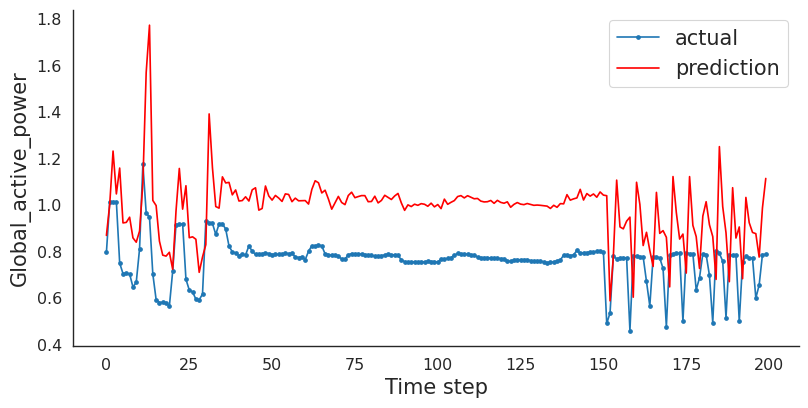

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_train[:200], marker='.', label="actual")
plt.plot(aa, train_predict[:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

/tmp/ipykernel_7670/2665350104.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


<Axes: ylabel='Density'>

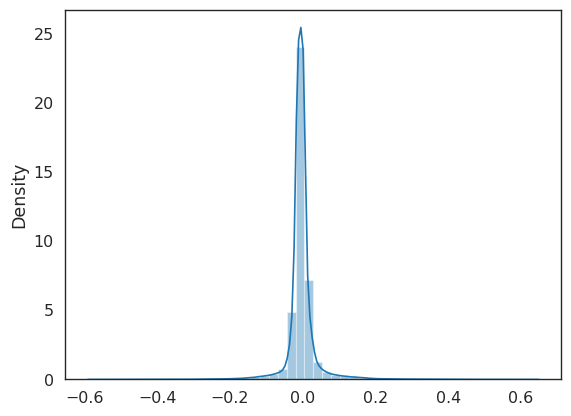

In [ ]:
residuals = Y_test - test_predict
sns.distplot(residuals)